# Loading Data/Packages

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm

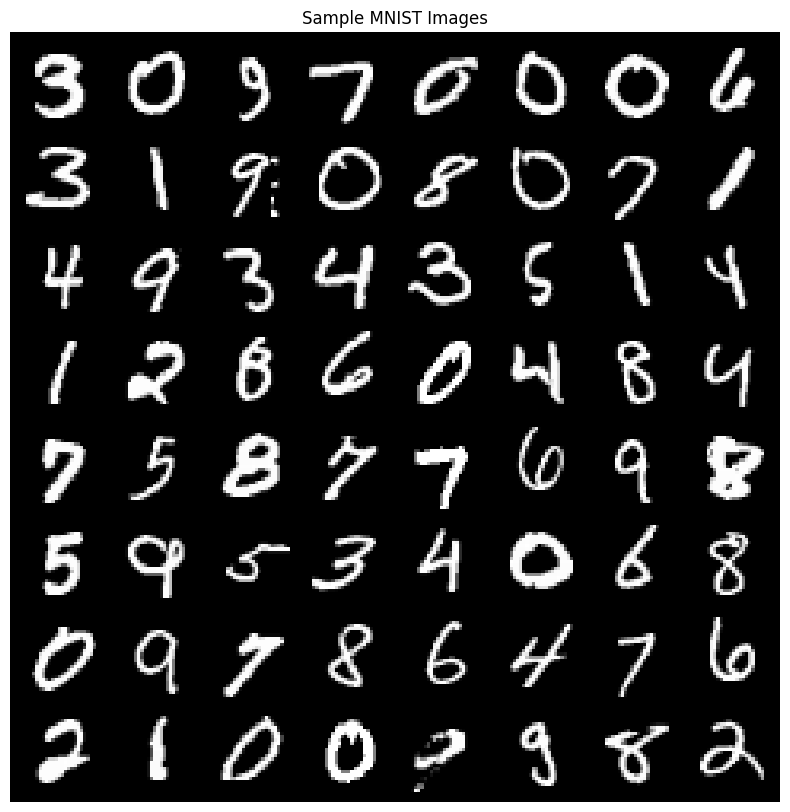

In [3]:
# Updated: Load MNIST dataset without normalization for binary cross-entropy
transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

# Function to visualize a batch of images
def show_images(images, title=""):
    grid_img = torchvision.utils.make_grid(images, nrow=8)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title(title)
    plt.axis("off")
    plt.show()

# Show some sample images
dataiter = iter(train_loader)
images, labels = next(dataiter)  # Correctly using next() function
show_images(images, title="Sample MNIST Images")

# Loss 1

In [4]:
LAMBDA = 1.2


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder layers
        self.fc1 = nn.Linear(28 * 28, 400)
        self.fc2_mu = nn.Linear(400, 20)   # Mean of the latent space
        self.fc2_logvar = nn.Linear(400, 20)  # Log variance of the latent space
        # Decoder layers
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 28 * 28)
    
    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        mu = self.fc2_mu(h1)
        logvar = self.fc2_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))  # Apply Sigmoid here to keep values in [0, 1]

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28 * 28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function for VAE with contrastive loss
def vae_loss(recon_x, x, mu, logvar, adv_x=None, recon_adv_x=None, margin=5.0):
    # Reconstruction loss for clean examples
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28 * 28), reduction='sum')
    
    # KL Divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Contrastive loss for adversarial examples (if provided)
    if adv_x is not None and recon_adv_x is not None:
        adv_loss = torch.mean(torch.clamp(margin - torch.sum((adv_x.view(-1, 28 * 28) - recon_adv_x) ** 2, dim=1), min=0.0))
        return recon_loss + kl_loss + LAMBDA * adv_loss # TODO: addd naive lambda thi hould be tuned
    else:
        print("No adversarial examples provided")
        return recon_loss + kl_loss

vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [ ]:
def train(epoch):
    vae.train()
    train_loss = 0
    from tqdm.notebook import tqdm
    
    for batch_idx, (data, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
        # Clean input
        data = data.to(torch.float32)
        clean_images = data.view(-1, 28 * 28)

        # Generate adversarial examples by adding noise
        noise = 0.5 * torch.randn_like(data)
        adv_images = (data + noise).clamp(0, 1).view(-1, 28 * 28)

        optimizer.zero_grad()
        
        # Forward pass for clean and adversarial examples
        recon_clean, mu, logvar = vae(clean_images)
        recon_adv, _, _ = vae(adv_images)
        
        # Compute loss
        loss = vae_loss(recon_clean, clean_images, mu, logvar, adv_images, recon_adv)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        # if batch_idx % 100 == 0:
        #     print(f'Epoch [{epoch}], Batch [{batch_idx}], Loss: {loss.item() / len(data)}')

    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset)}')

for epoch in range(1, 6):
    train(epoch)


938it [00:17, 53.49it/s]


====> Epoch: 1 Average loss: 146.64454674479165


938it [00:16, 58.12it/s]


====> Epoch: 2 Average loss: 115.43637065836589


938it [00:15, 58.81it/s]


====> Epoch: 3 Average loss: 111.14210331217448


938it [00:16, 57.74it/s]


====> Epoch: 4 Average loss: 109.24068216552735


938it [00:16, 55.50it/s]

====> Epoch: 5 Average loss: 108.07017069498698


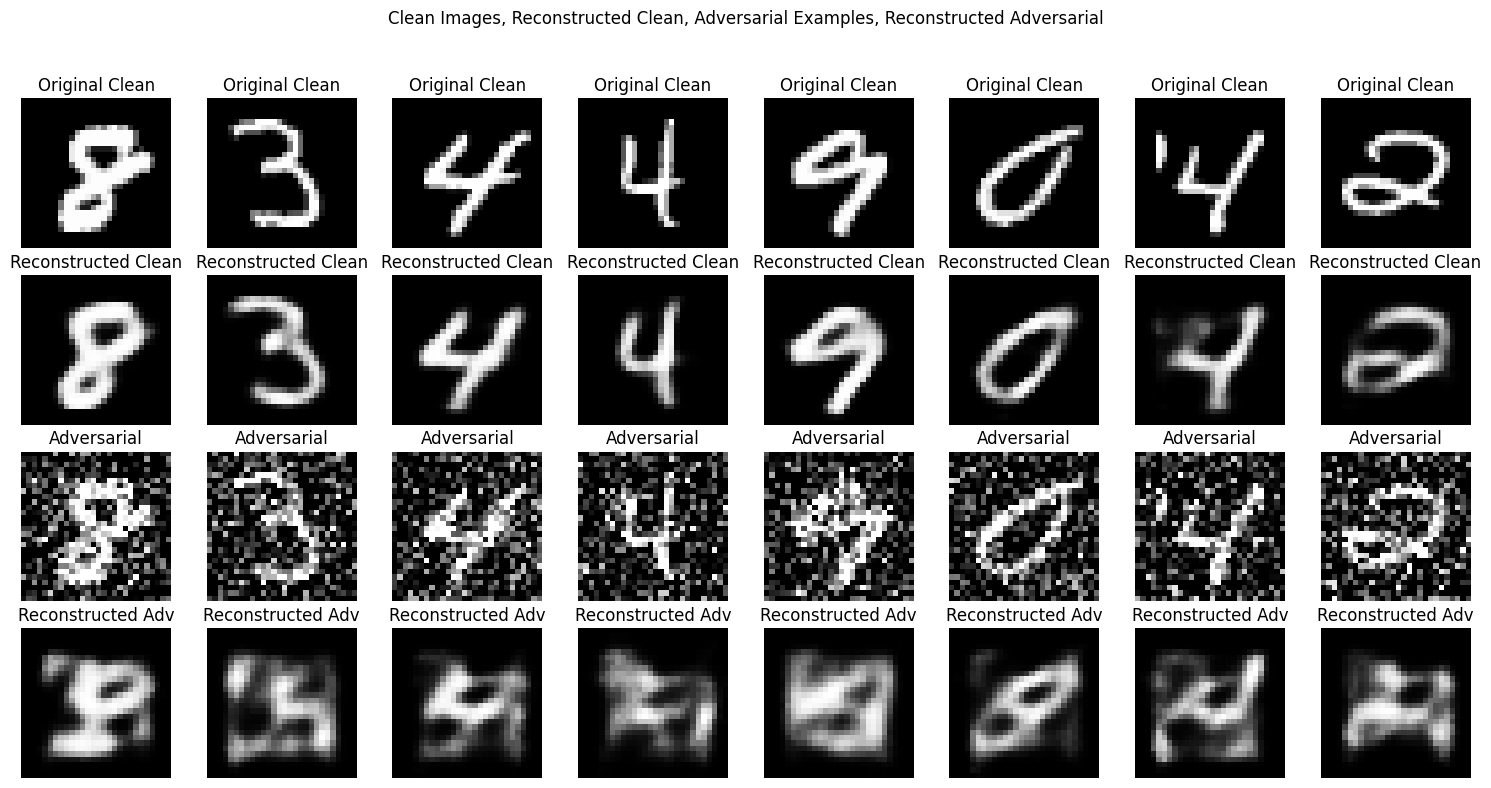

In [ ]:
# Visualize original clean images, reconstructed clean images, adversarial examples, and their reconstructions
def visualize_results():
    vae.eval()
    
    with torch.no_grad():
        # Sample batch of clean images
        dataiter = iter(train_loader)
        images, labels = next(dataiter)  # Correctly using next() function
        clean_images = images.view(-1, 28 * 28).to(torch.float32)

        # Generate adversarial examples by adding noise
        noise = 0.4* torch.randn_like(images)
        adv_images = (images + noise).clamp(0, 1).view(-1, 28 * 28)

        # Reconstruct clean and adversarial examples
        recon_clean, _, _ = vae(clean_images)
        recon_adv, _, _ = vae(adv_images)

        # Visualize results
        fig, axes = plt.subplots(4, 8, figsize=(15, 8))
        fig.suptitle("Clean Images, Reconstructed Clean, Adversarial Examples, Reconstructed Adversarial")
        
        for i in range(8):
            # Original Clean Images
            axes[0, i].imshow(clean_images[i].view(28, 28).cpu().numpy(), cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title("Original Clean")

            # Reconstructed Clean Images
            axes[1, i].imshow(recon_clean[i].view(28, 28).cpu().numpy(), cmap='gray')
            axes[1, i].axis('off')
            axes[1, i].set_title("Reconstructed Clean")

            # Adversarial Examples
            axes[2, i].imshow(adv_images[i].view(28, 28).cpu().numpy(), cmap='gray')
            axes[2, i].axis('off')
            axes[2, i].set_title("Adversarial")

            # Reconstructed Adversarial Examples
            axes[3, i].imshow(recon_adv[i].view(28, 28).cpu().numpy(), cmap='gray')
            axes[3, i].axis('off')
            axes[3, i].set_title("Reconstructed Adv")

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

# Call the visualization function
visualize_results()

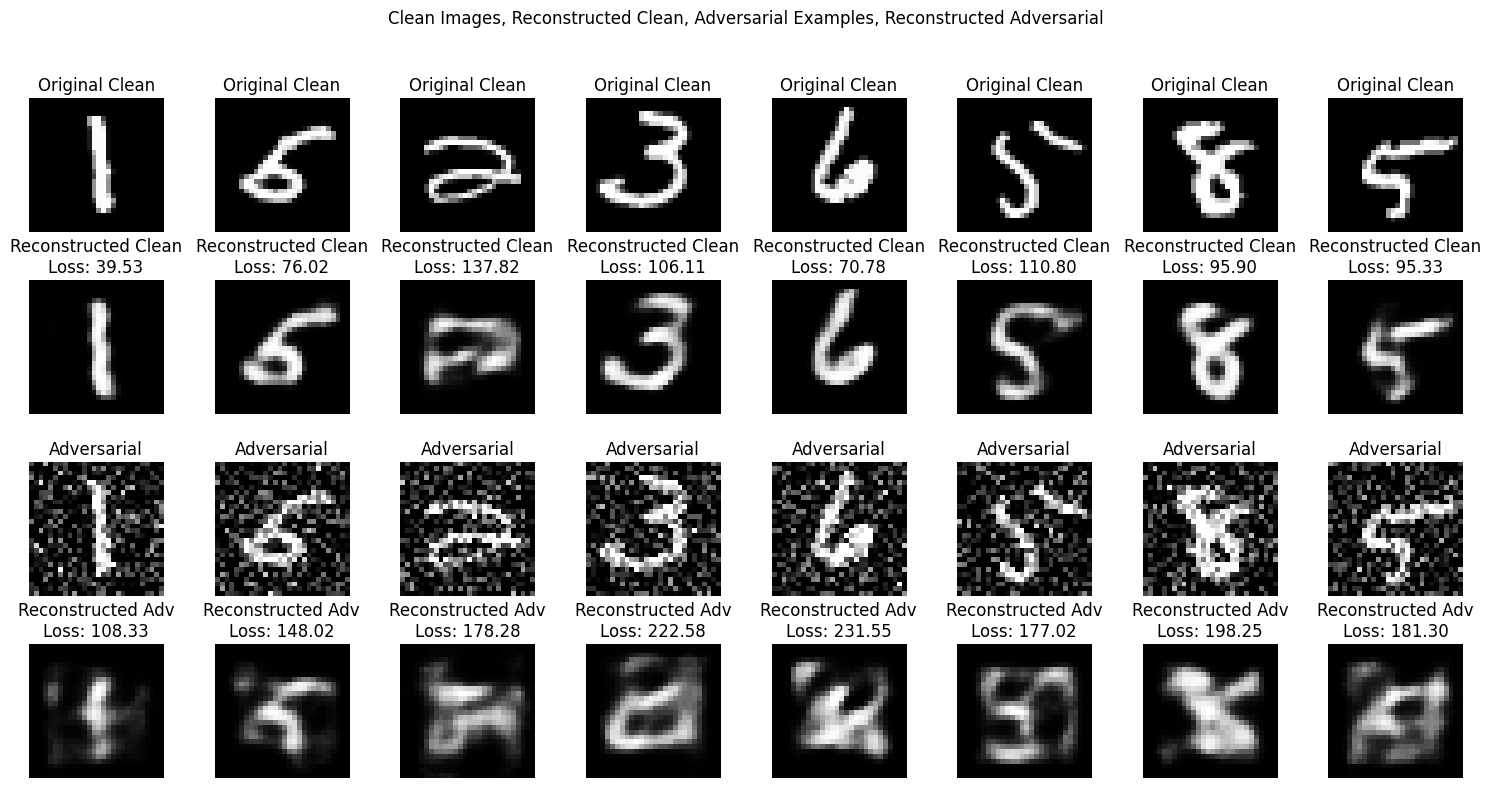

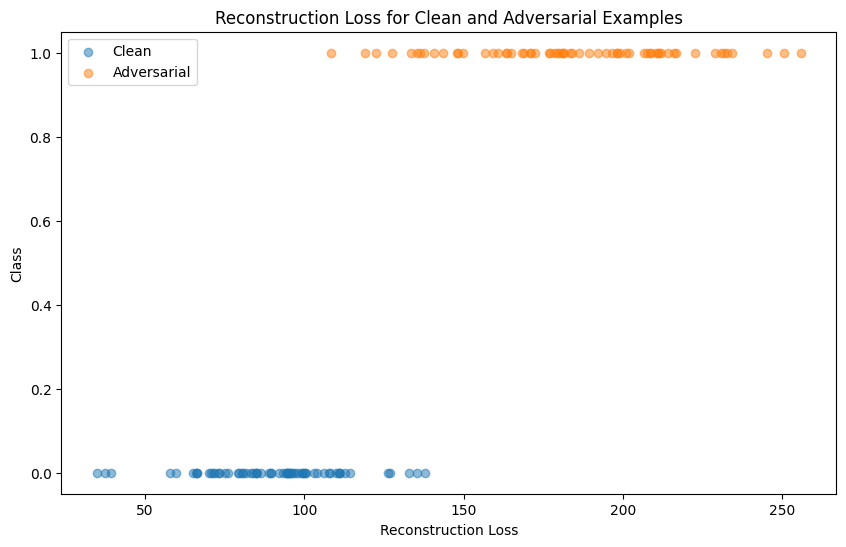

In [6]:
NOISE_LEVEL = 0.3

# Visualize original clean images, reconstructed clean images, adversarial examples, and their reconstructions
def visualize_results():
    vae.eval()
    
    with torch.no_grad():
        # Sample batch of clean images
        dataiter = iter(train_loader)
        images, labels = next(dataiter)  # Correctly using next() function
        clean_images = images.view(-1, 28 * 28).to(torch.float32)

        # Generate adversarial examples by adding noise
        noise = NOISE_LEVEL * torch.randn_like(images)
        adv_images = (images + noise).clamp(0, 1).view(-1, 28 * 28)

        # Reconstruct clean and adversarial examples
        recon_clean, _, _ = vae(clean_images)
        recon_adv, _, _ = vae(adv_images)

        # Compute reconstruction loss for clean and adversarial examples
        recon_loss_clean = nn.functional.binary_cross_entropy(recon_clean, clean_images, reduction='none').sum(dim=1)
        recon_loss_adv = nn.functional.binary_cross_entropy(recon_adv, clean_images, reduction='none').sum(dim=1)

        # Visualize results
        fig, axes = plt.subplots(4, 8, figsize=(15, 8))
        fig.suptitle("Clean Images, Reconstructed Clean, Adversarial Examples, Reconstructed Adversarial")
        
        for i in range(8):
            # Original Clean Images
            axes[0, i].imshow(clean_images[i].view(28, 28).cpu().numpy(), cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title("Original Clean")

            # Reconstructed Clean Images
            axes[1, i].imshow(recon_clean[i].view(28, 28).cpu().numpy(), cmap='gray')
            axes[1, i].axis('off')
            axes[1, i].set_title(f"Reconstructed Clean\nLoss: {recon_loss_clean[i].item():.2f}")

            # Adversarial Examples
            axes[2, i].imshow(adv_images[i].view(28, 28).cpu().numpy(), cmap='gray')
            axes[2, i].axis('off')
            axes[2, i].set_title("Adversarial")

            # Reconstructed Adversarial Examples
            axes[3, i].imshow(recon_adv[i].view(28, 28).cpu().numpy(), cmap='gray')
            axes[3, i].axis('off')
            axes[3, i].set_title(f"Reconstructed Adv\nLoss: {recon_loss_adv[i].item():.2f}")

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

        # Plot reconstruction losses
        plt.figure(figsize=(10, 6))
        plt.scatter(recon_loss_clean.cpu().numpy(), np.zeros_like(recon_loss_clean.cpu().numpy()), label='Clean', alpha=0.5)
        plt.scatter(recon_loss_adv.cpu().numpy(), np.ones_like(recon_loss_adv.cpu().numpy()), label='Adversarial', alpha=0.5)
        plt.xlabel('Reconstruction Loss')
        plt.ylabel('Class')
        plt.title('Reconstruction Loss for Clean and Adversarial Examples')
        plt.legend()
        plt.show()
# Call the visualization function
visualize_results()

In [5]:
# Parameters
NOISE_LEVEL = 0.4
EPOCHS = 6


# Updated loss function to prioritize reconstructing adversarial examples well
def contrastive_vae_loss(recon_x, x, mu_clean, logvar_clean, adv_x, recon_adv_x, mu_adv, logvar_adv, margin=5.0):
    # 1. Reconstruction Loss for Clean Examples
    recon_loss_clean = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28 * 28), reduction='sum')

    # 2. Reconstruction Loss for Adversarial Examples
    recon_loss_adv = nn.functional.binary_cross_entropy(recon_adv_x, adv_x.view(-1, 28 * 28), reduction='sum')

    # 3. KL Divergence Loss for Clean Examples
    kl_loss_clean = -0.5 * torch.sum(1 + logvar_clean - mu_clean.pow(2) - logvar_clean.exp())

    # 4. KL Divergence Loss for Adversarial Examples
    kl_loss_adv = -0.5 * torch.sum(1 + logvar_adv - mu_adv.pow(2) - logvar_adv.exp())

    # 5. Contrastive Latent Loss (penalize closeness between clean and adversarial latent vectors)
    latent_distance = torch.norm(mu_clean - mu_adv, p=2)  # L2 distance between means of clean and adversarial latent codes
    contrastive_loss = torch.clamp(margin - latent_distance, min=0)  # If latent_distance > margin, contrastive_loss = 0

    # Total loss
    return 3*recon_loss_adv + kl_loss_clean + kl_loss_adv + 3*latent_distance # + recon_loss_adv + 4*kl_loss_adv + latent_distance

# Updated training function using the reversed loss
for epoch in range(1, EPOCHS):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 28 * 28).to(torch.float32)
        
        # Generate adversarial examples
        noise = NOISE_LEVEL * torch.randn_like(data)
        adv_images = (data + noise).clamp(0, 1)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass for clean and adversarial images
        recon_clean, mu, logvar = vae(data)
        recon_adv, mu_adv, logvar_adv = vae(adv_images)

        # Compute the reverse loss
        loss = contrastive_vae_loss(recon_clean, data, mu, logvar, adv_images, recon_adv, mu_adv, logvar_adv)
        loss.backward()
        train_loss += loss.item()
        
        # Update parameters
        optimizer.step()

    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset)}')


====> Epoch: 1 Average loss: 1170.9935276692709
====> Epoch: 2 Average loss: 1150.4157911458333
====> Epoch: 3 Average loss: 1146.0457860677084
====> Epoch: 4 Average loss: 1144.14115625
====> Epoch: 5 Average loss: 1142.9627618489583


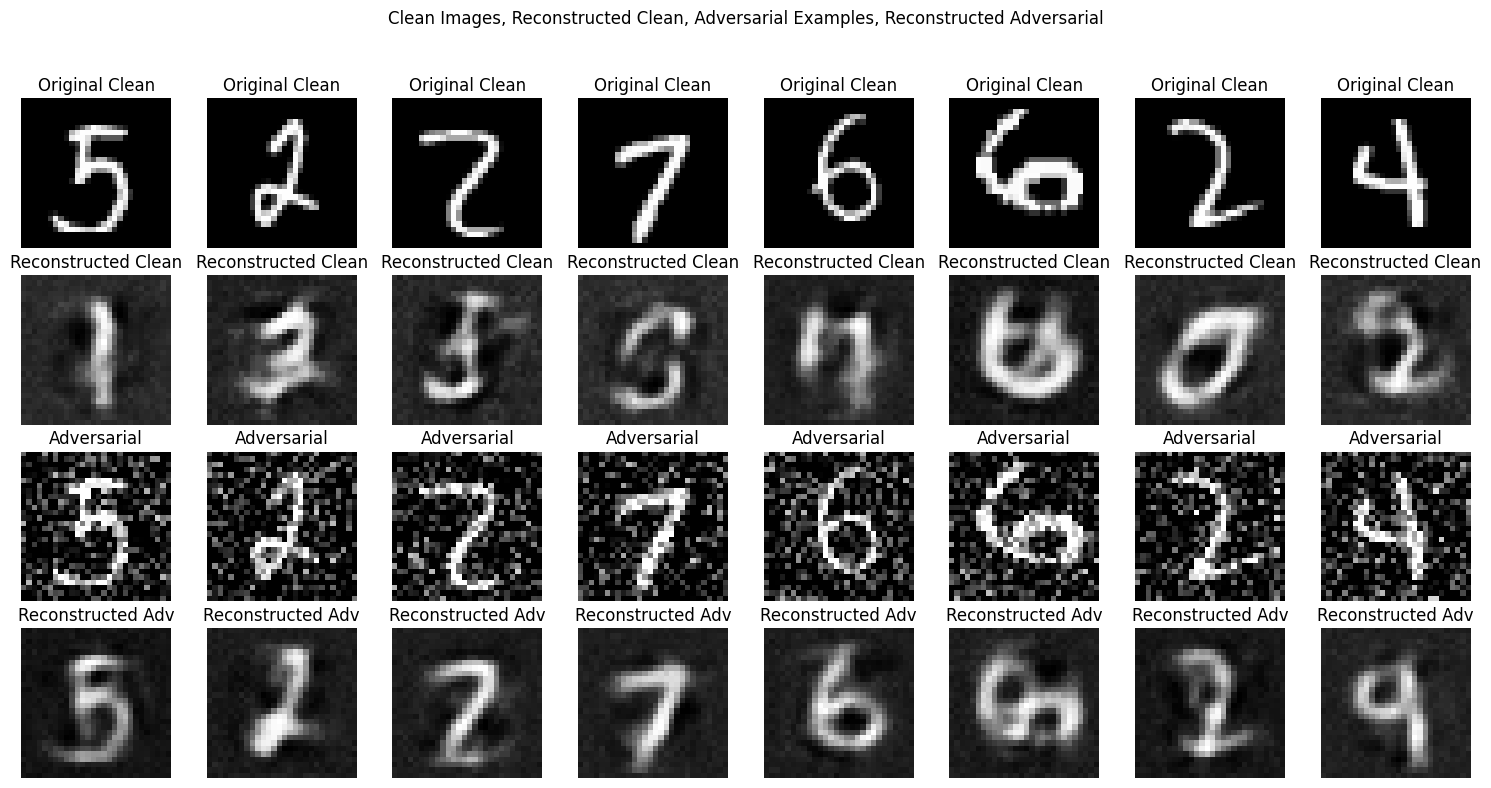

In [7]:
NOISE_LEVEL = 0.3

# Visualize original clean images, reconstructed clean images, adversarial examples, and their reconstructions
def visualize_results():
    vae.eval()
    
    with torch.no_grad():
        # Sample batch of clean images
        dataiter = iter(train_loader)
        images, labels = next(dataiter)  # Correctly using next() function
        clean_images = images.view(-1, 28 * 28).to(torch.float32)

        # Generate adversarial examples by adding noise
        noise = NOISE_LEVEL * torch.randn_like(images)
        adv_images = (images + noise).clamp(0, 1).view(-1, 28 * 28)

        # Reconstruct clean and adversarial examples
        recon_clean, _, _ = vae(clean_images)
        recon_adv, _, _ = vae(adv_images)

        # Visualize results
        fig, axes = plt.subplots(4, 8, figsize=(15, 8))
        fig.suptitle("Clean Images, Reconstructed Clean, Adversarial Examples, Reconstructed Adversarial")
        
        for i in range(8):
            # Original Clean Images
            axes[0, i].imshow(clean_images[i].view(28, 28).cpu().numpy(), cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title("Original Clean")

            # Reconstructed Clean Images
            axes[1, i].imshow(recon_clean[i].view(28, 28).cpu().numpy(), cmap='gray')
            axes[1, i].axis('off')
            axes[1, i].set_title("Reconstructed Clean")

            # Adversarial Examples
            axes[2, i].imshow(adv_images[i].view(28, 28).cpu().numpy(), cmap='gray')
            axes[2, i].axis('off')
            axes[2, i].set_title("Adversarial")

            # Reconstructed Adversarial Examples
            axes[3, i].imshow(recon_adv[i].view(28, 28).cpu().numpy(), cmap='gray')
            axes[3, i].axis('off')
            axes[3, i].set_title("Reconstructed Adv")

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

# Call the visualization function
visualize_results()


In [8]:
# Parameters
NOISE_LEVEL = 0.3
EPOCHS = 6


# Updated loss function to prioritize reconstructing adversarial examples well
def contrastive_vae_loss(recon_x, x, mu_clean, logvar_clean, adv_x, recon_adv_x, mu_adv, logvar_adv, margin=5.0):
    # 1. Reconstruction Loss for Clean Examples
    recon_loss_clean = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28 * 28), reduction='sum')

    # 2. Reconstruction Loss for Adversarial Examples
    recon_loss_adv = nn.functional.binary_cross_entropy(recon_adv_x, adv_x.view(-1, 28 * 28), reduction='sum')

    # 3. KL Divergence Loss for Clean Examples
    kl_loss_clean = -0.5 * torch.sum(1 + logvar_clean - mu_clean.pow(2) - logvar_clean.exp())

    # 4. KL Divergence Loss for Adversarial Examples
    kl_loss_adv = -0.5 * torch.sum(1 + logvar_adv - mu_adv.pow(2) - logvar_adv.exp())

    # 5. Contrastive Latent Loss (penalize closeness between clean and adversarial latent vectors)
    latent_distance = torch.norm(mu_clean - mu_adv, p=2)  # L2 distance between means of clean and adversarial latent codes
    contrastive_loss = torch.clamp(margin - latent_distance, min=0)  # If latent_distance > margin, contrastive_loss = 0

    # Total loss
    return recon_loss_adv + kl_loss_adv

# Updated training function using the reversed loss
for epoch in range(1, EPOCHS):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 28 * 28).to(torch.float32)
        
        # Generate adversarial examples
        noise = NOISE_LEVEL * torch.randn_like(data)
        adv_images = (data + noise).clamp(0, 1)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass for clean and adversarial images
        recon_clean, mu, logvar = vae(data)
        recon_adv, mu_adv, logvar_adv = vae(adv_images)

        # Compute the reverse loss
        loss = contrastive_vae_loss(recon_clean, data, mu, logvar, adv_images, recon_adv, mu_adv, logvar_adv)
        loss.backward()
        train_loss += loss.item()
        
        # Update parameters
        optimizer.step()

    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset)}')


====> Epoch: 1 Average loss: 346.2002847167969
====> Epoch: 2 Average loss: 345.834362890625
====> Epoch: 3 Average loss: 345.90572872721356
====> Epoch: 4 Average loss: 345.8106322591146
====> Epoch: 5 Average loss: 345.7806959472656


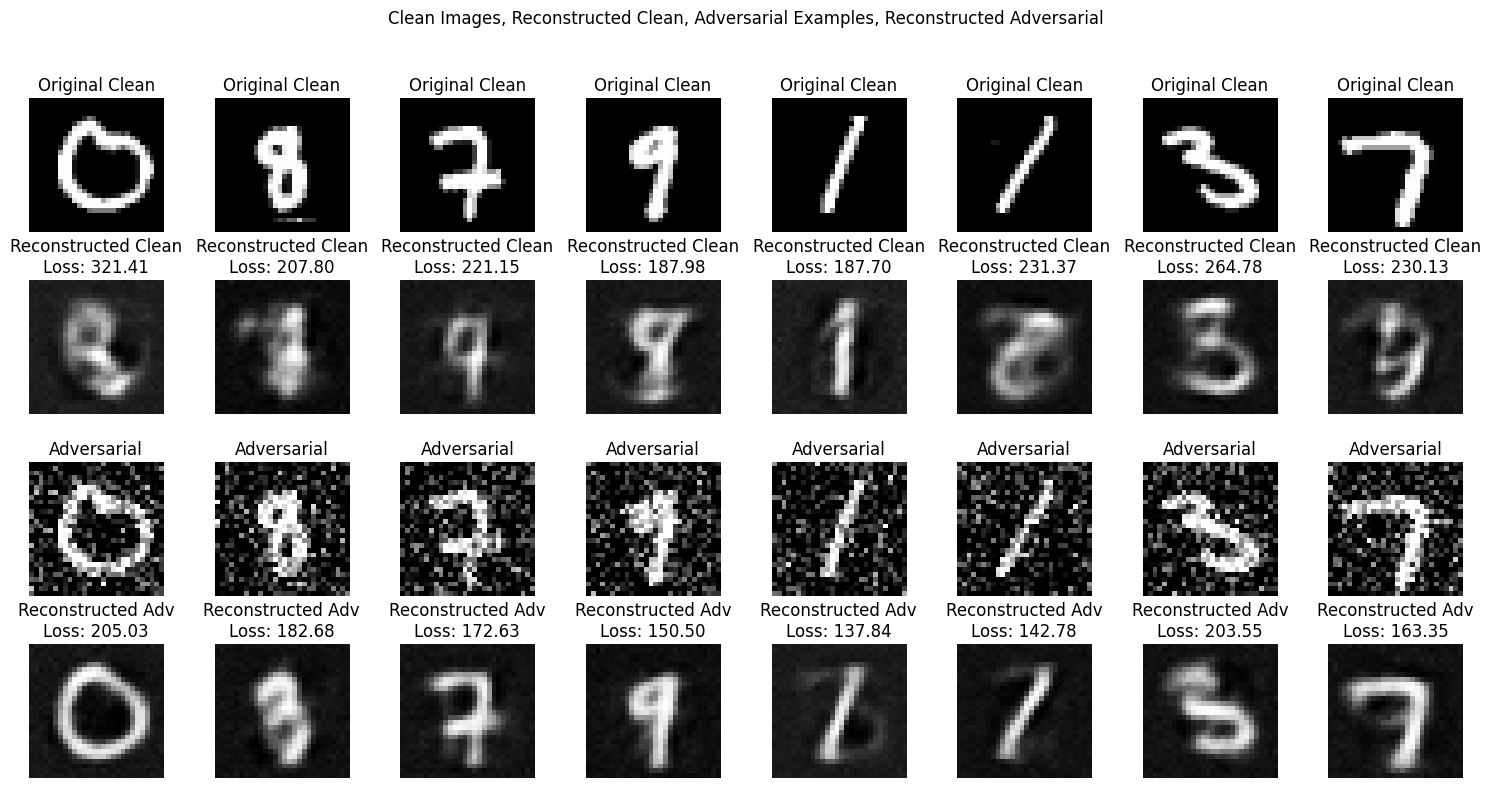

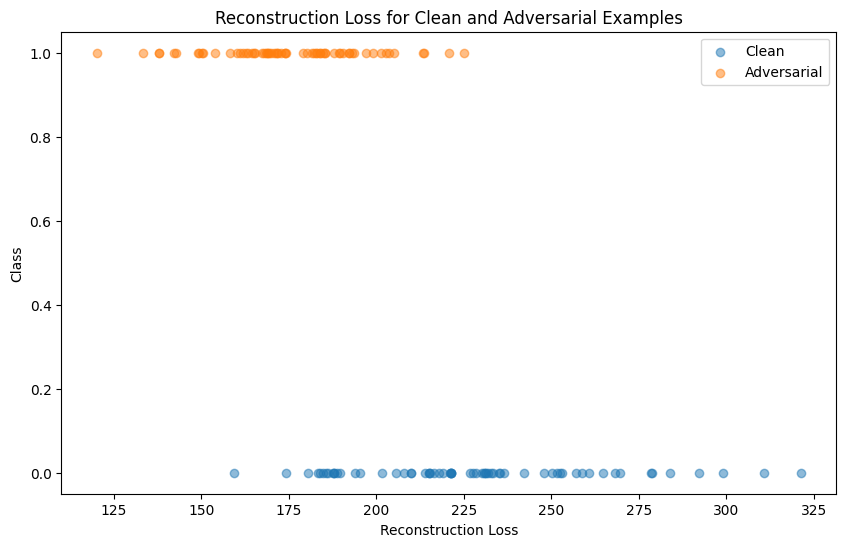

In [ ]:
# Visualize original clean images, reconstructed clean images, adversarial examples, and their reconstructions
def visualize_results():
    vae.eval()
    
    with torch.no_grad():
        # Sample batch of clean images
        dataiter = iter(train_loader)
        images, labels = next(dataiter)  # Correctly using next() function
        clean_images = images.view(-1, 28 * 28).to(torch.float32)

        # Generate adversarial examples by adding noise
        noise = NOISE_LEVEL * torch.randn_like(images)
        adv_images = (images + noise).clamp(0, 1).view(-1, 28 * 28)

        # Reconstruct clean and adversarial examples
        recon_clean, _, _ = vae(clean_images)
        recon_adv, _, _ = vae(adv_images)

        # Compute reconstruction loss for clean and adversarial examples
        recon_loss_clean = nn.functional.binary_cross_entropy(recon_clean, clean_images, reduction='none').sum(dim=1)
        recon_loss_adv = nn.functional.binary_cross_entropy(recon_adv, clean_images, reduction='none').sum(dim=1)

        # Visualize results
        fig, axes = plt.subplots(4, 8, figsize=(15, 8))
        fig.suptitle("Clean Images, Reconstructed Clean, Adversarial Examples, Reconstructed Adversarial")
        
        for i in range(8):
            # Original Clean Images
            axes[0, i].imshow(clean_images[i].view(28, 28).cpu().numpy(), cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title("Original Clean")

            # Reconstructed Clean Images
            axes[1, i].imshow(recon_clean[i].view(28, 28).cpu().numpy(), cmap='gray')
            axes[1, i].axis('off')
            axes[1, i].set_title(f"Reconstructed Clean\nLoss: {recon_loss_clean[i].item():.2f}")

            # Adversarial Examples
            axes[2, i].imshow(adv_images[i].view(28, 28).cpu().numpy(), cmap='gray')
            axes[2, i].axis('off')
            axes[2, i].set_title("Adversarial")

            # Reconstructed Adversarial Examples
            axes[3, i].imshow(recon_adv[i].view(28, 28).cpu().numpy(), cmap='gray')
            axes[3, i].axis('off')
            axes[3, i].set_title(f"Reconstructed Adv\nLoss: {recon_loss_adv[i].item():.2f}")

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

        # Plot reconstruction losses
        plt.figure(figsize=(10, 6))
        plt.scatter(recon_loss_clean.cpu().numpy(), np.zeros_like(recon_loss_clean.cpu().numpy()), label='Clean', alpha=0.5)
        plt.scatter(recon_loss_adv.cpu().numpy(), np.ones_like(recon_loss_adv.cpu().numpy()), label='Adversarial', alpha=0.5)
        plt.xlabel('Reconstruction Loss')
        plt.ylabel('Class')
        plt.title('Reconstruction Loss for Clean and Adversarial Examples')
        plt.legend()
        plt.show()
# Call the visualization function
visualize_results()

====> Epoch: 1 Average loss: 358.98555758463544
====> Epoch: 2 Average loss: 356.1695335611979
====> Epoch: 3 Average loss: 353.75156971028645
====> Epoch: 4 Average loss: 351.78654677734374
====> Epoch: 5 Average loss: 350.09519967447915


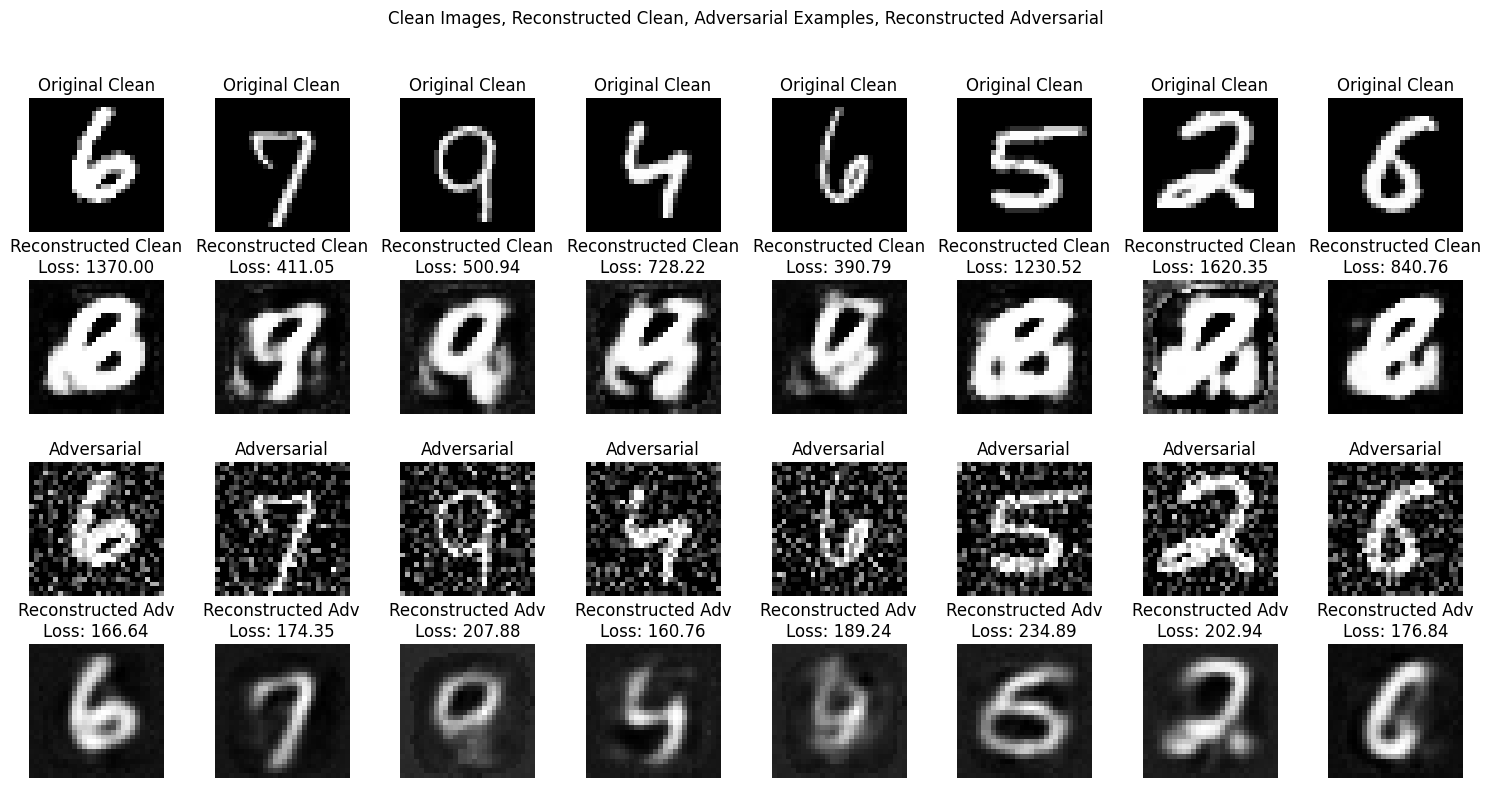

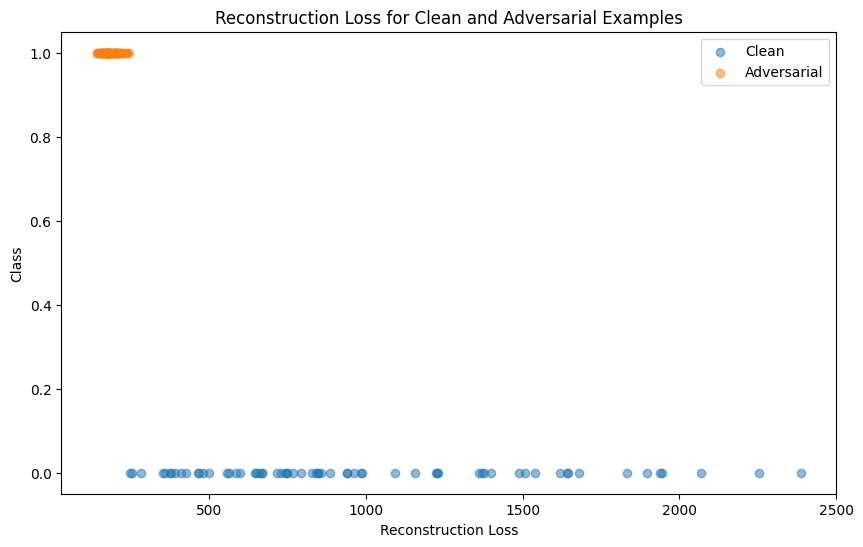

In [ ]:
# Parameters
NOISE_LEVEL = 0.3
EPOCHS = 6
MARGIN = 300.0

import math


# Updated loss function to prioritize reconstructing adversarial examples well
def new_vae_loss(recon_x, x, mu_clean, logvar_clean, adv_x, recon_adv_x, mu_adv, logvar_adv, margin=5.0):
    # 1. Reconstruction Loss for Clean Examples
    recon_loss_clean = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28 * 28), reduction='sum')

    # 2. Reconstruction Loss for Adversarial Examples
    recon_loss_adv = nn.functional.binary_cross_entropy(recon_adv_x, adv_x.view(-1, 28 * 28), reduction='sum')

    # 3. KL Divergence Loss for Clean Examples
    kl_loss_clean = -0.5 * torch.sum(1 + logvar_clean - mu_clean.pow(2) - logvar_clean.exp())

    # 4. KL Divergence Loss for Adversarial Examples
    kl_loss_adv = -0.5 * torch.sum(1 + logvar_adv - mu_adv.pow(2) - logvar_adv.exp())

    # 5. Contrastive Latent Loss (penalize closeness between clean and adversarial latent vectors)
    latent_distance = torch.norm(mu_clean - mu_adv, p=2)  # L2 distance between means of clean and adversarial latent codes
    contrastive_loss = torch.clamp(margin - latent_distance, min=0)  # If latent_distance > margin, contrastive_loss = 0

    # Total loss
    return recon_loss_adv + kl_loss_adv + contrastive_loss # + math.sqrt((MARGIN - recon_loss_clean)**2) 

# Updated training function using the reversed loss
for epoch in range(1, EPOCHS):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 28 * 28).to(torch.float32)
        
        # Generate adversarial examples
        noise = NOISE_LEVEL * torch.randn_like(data)
        adv_images = (data + noise).clamp(0, 1)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass for clean and adversarial images
        recon_clean, mu, logvar = vae(data)
        recon_adv, mu_adv, logvar_adv = vae(adv_images)

        # Compute the reverse loss
        loss = new_vae_loss(recon_clean, data, mu, logvar, adv_images, recon_adv, mu_adv, logvar_adv)
        loss.backward()
        train_loss += loss.item()
        
        # Update parameters
        optimizer.step()

    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset)}')

visualize_results()

====> Epoch: 1 Average loss: 347.0497350260417
====> Epoch: 2 Average loss: 346.82224568684893
====> Epoch: 3 Average loss: 346.59134169921873
====> Epoch: 4 Average loss: 346.39726357421875
====> Epoch: 5 Average loss: 346.3207559733073


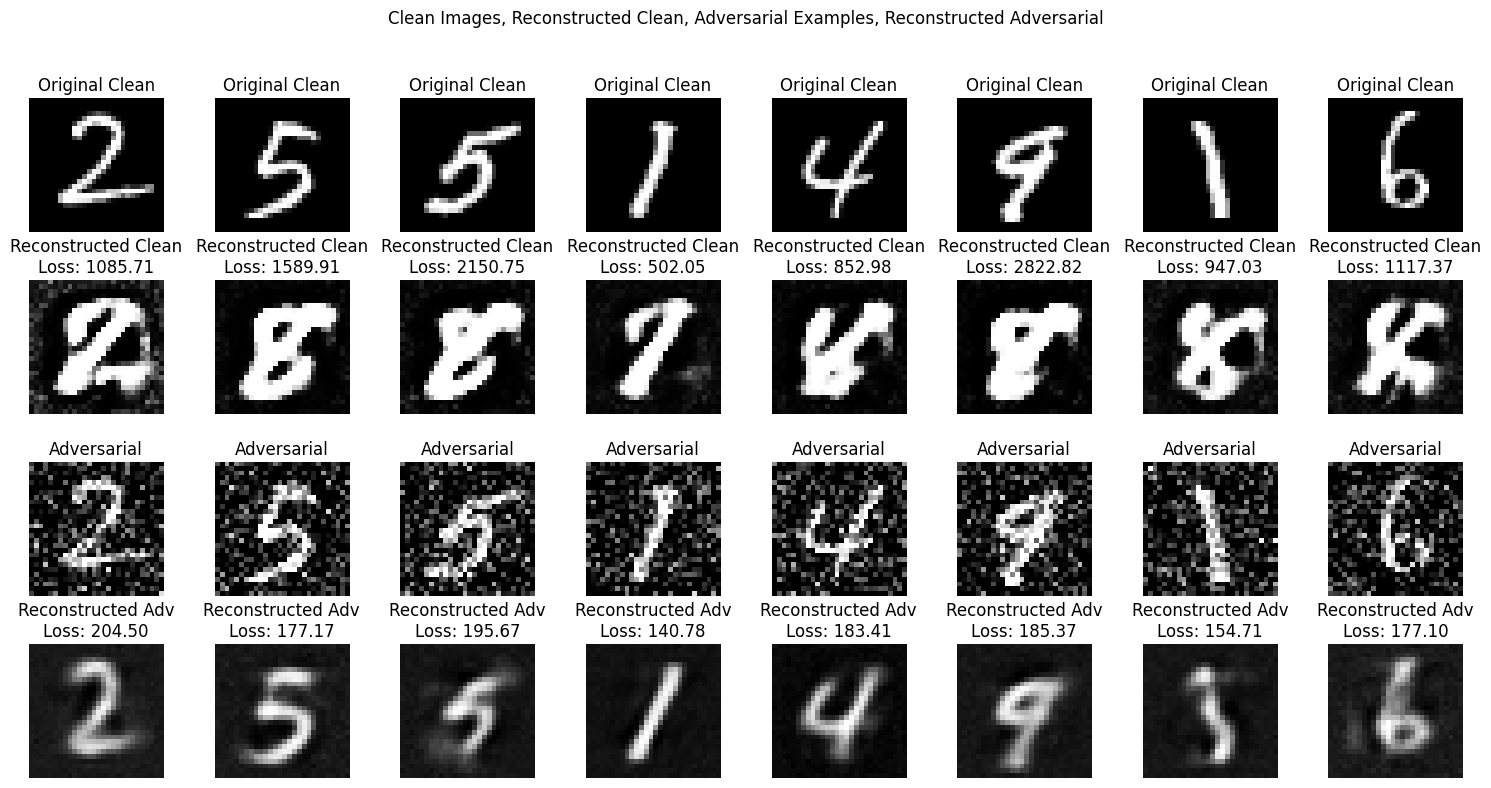

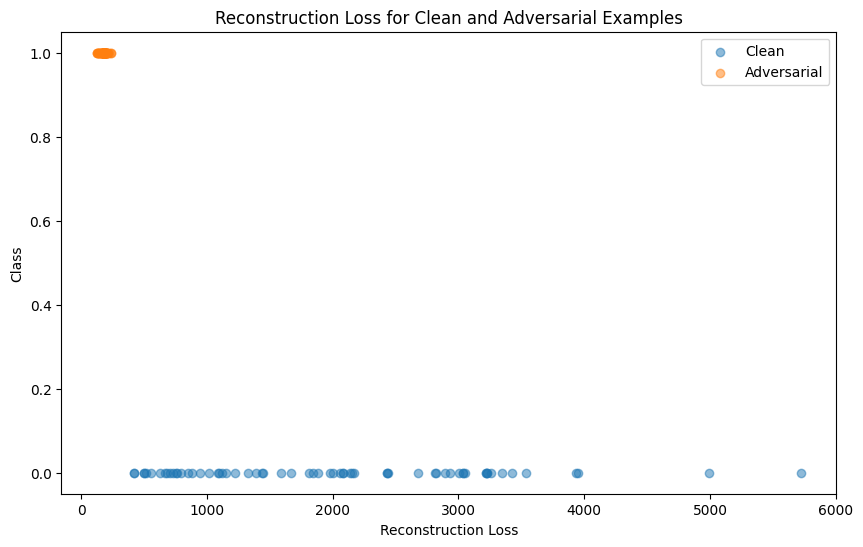

In [14]:
# Parameters
NOISE_LEVEL = 0.3
EPOCHS = 6
MARGIN = 250.0

import torch
import torch.nn.functional as F


# Updated loss function to prioritize reconstructing adversarial examples well
def contrastive_vae_loss(recon_noisy, noisy_input, recon_clean, clean_input, mu, logvar, alpha=2, beta=0.5, gamma=0.1):
    """
    Computes a contrastive VAE loss that maximizes reconstruction for noisy inputs 
    while minimizing reconstruction for clean inputs to achieve separability.
    
    Parameters:
    - recon_noisy: VAE reconstruction for the noisy input
    - noisy_input: Original noisy (adversarial) input
    - recon_clean: VAE reconstruction for the clean input
    - clean_input: Original clean input
    - mu, logvar: Mean and log-variance from the encoder
    - margin: Target margin for poor clean reconstructions
    - alpha, beta, gamma: Weighting coefficients for each loss component
    
    Returns:
    - loss: The computed contrastive VAE loss
    """
    
    # 1. Noisy Reconstruction Loss (to be minimized)
    recon_loss_noisy = F.mse_loss(recon_noisy, noisy_input.view(-1, 28*28), reduction='sum')
    
    # 2. Clean Reconstruction Loss (contrastive component to be maximized)
    recon_loss_clean = F.mse_loss(recon_clean, clean_input.view(-1, 28*28), reduction='none')
    recon_loss_clean = torch.sum((MARGIN - recon_loss_clean.sum(dim=1)).clamp(min=0.0)**2)
    
    # 3. KL Divergence Loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # 4. Total Loss
    total_loss = (alpha * recon_loss_noisy) + (beta * recon_loss_clean) + (gamma * kl_loss)
    
    return total_loss


# Updated training function using the reversed loss
for epoch in range(1, EPOCHS):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 28 * 28).to(torch.float32)
        
        # Generate adversarial examples
        noise = NOISE_LEVEL * torch.randn_like(data)
        adv_images = (data + noise).clamp(0, 1)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass for clean and adversarial images
        recon_clean, mu, logvar = vae(data)
        recon_adv, mu_adv, logvar_adv = vae(adv_images)

        # Compute the reverse loss
        loss = new_vae_loss(recon_clean, data, mu, logvar, adv_images, recon_adv, mu_adv, logvar_adv)
        loss.backward()
        train_loss += loss.item()
        
        # Update parameters
        optimizer.step()

    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset)}')

visualize_results()

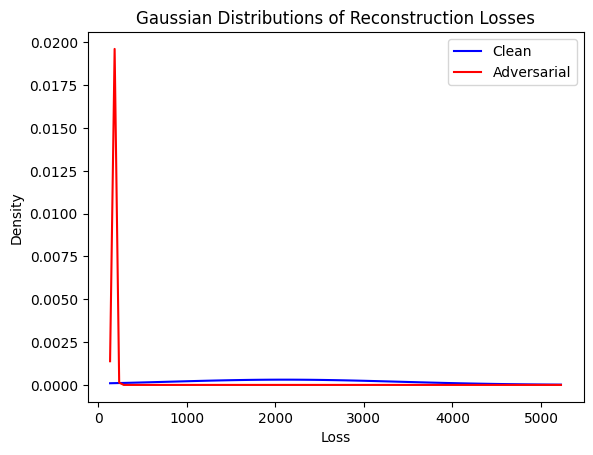

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import json

def g_dist():
    vae.eval()
    
    with torch.no_grad():
        # Sample batch of clean images
        dataiter = iter(train_loader)
        images, labels = next(dataiter)  # Correctly using next() function
        clean_images = images.view(-1, 28 * 28).to(torch.float32)

        # Generate adversarial examples by adding noise
        noise = NOISE_LEVEL * torch.randn_like(images)
        adv_images = (images + noise).clamp(0, 1).view(-1, 28 * 28)

        # Reconstruct clean and adversarial examples
        recon_clean, _, _ = vae(clean_images)
        recon_adv, _, _ = vae(adv_images)

        # Compute reconstruction loss for clean and adversarial examples
        recon_loss_clean = nn.functional.binary_cross_entropy(recon_clean, clean_images, reduction='none').sum(dim=1)
        recon_loss_adv = nn.functional.binary_cross_entropy(recon_adv, clean_images, reduction='none').sum(dim=1)

        # Assuming recon_loss_clean and recon_loss_adv are lists or arrays of losses
        recon_loss_clean = [recon_loss_clean[i].item() for i in range(len(recon_loss_clean))]
        recon_loss_adv = [recon_loss_adv[i].item() for i in range(len(recon_loss_adv))]

        # Fit Gaussian distributions
        mu_clean, std_clean = norm.fit(recon_loss_clean)
        mu_adv, std_adv = norm.fit(recon_loss_adv)

        # Save Gaussian parameters to a JSON file
        gaussian_params = {
            'clean': {'mu': mu_clean, 'std': std_clean},
            'adversarial': {'mu': mu_adv, 'std': std_adv}
        }
        with open('gaussian_params.json', 'w') as f:
            json.dump(gaussian_params, f)

        # Plot the distributions
        x = np.linspace(min(min(recon_loss_clean), min(recon_loss_adv)), max(max(recon_loss_clean), max(recon_loss_adv)), 100)

        p_clean = norm.pdf(x, mu_clean, std_clean)
        p_adv = norm.pdf(x, mu_adv, std_adv)

        plt.plot(x, p_clean, 'b', label='Clean')
        plt.plot(x, p_adv, 'r', label='Adversarial')
        plt.title('Gaussian Distributions of Reconstruction Losses')
        plt.xlabel('Loss')
        plt.ylabel('Density')
        plt.legend()
    plt.show()

    return recon_loss_clean, recon_loss_adv

rlc, rla = g_dist()

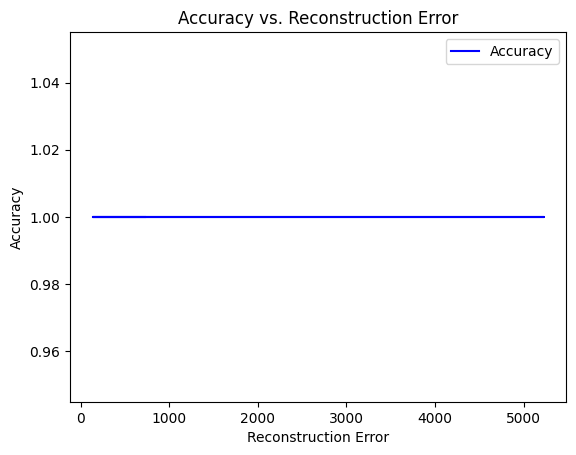

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import json

# Load Gaussian parameters from JSON file
with open('gaussian_params.json', 'r') as f:
    gaussian_params = json.load(f)

mu_clean = gaussian_params['clean']['mu']
std_clean = gaussian_params['clean']['std']
mu_adv = gaussian_params['adversarial']['mu']
std_adv = gaussian_params['adversarial']['std']

# Function to calculate accuracy vs. reconstruction error
def plot_accuracy_vs_recon_error(recon_loss_clean, recon_loss_adv):
    # Combine clean and adversarial losses
    recon_losses = recon_loss_clean + recon_loss_adv
    labels = [0] * len(recon_loss_clean) + [1] * len(recon_loss_adv)  # 0 for clean, 1 for adversarial

    # Calculate probabilities
    p_clean = norm.pdf(recon_losses, mu_clean, std_clean)
    p_adv = norm.pdf(recon_losses, mu_adv, std_adv)

    # Determine predicted labels
    predicted_labels = [0 if p_clean[i] > p_adv[i] else 1 for i in range(len(recon_losses))]

    # Calculate accuracy
    accuracy = [1 if predicted_labels[i] == labels[i] else 0 for i in range(len(labels))]
    accuracy = np.cumsum(accuracy) / np.arange(1, len(accuracy) + 1)

    # Plot accuracy vs. reconstruction error
    plt.plot(recon_losses, accuracy, 'b', label='Accuracy')
    plt.title('Accuracy vs. Reconstruction Error')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Example reconstruction losses (replace with actual data)
recon_loss_clean = rlc
recon_loss_adv = rla

plot_accuracy_vs_recon_error(recon_loss_clean, recon_loss_adv)

====> Epoch: 1 Average loss: 812.4912663085937
====> Epoch: 2 Average loss: 805.3825913736979
====> Epoch: 3 Average loss: 802.1615936523438
====> Epoch: 4 Average loss: 800.2052217447916
====> Epoch: 5 Average loss: 798.763370703125


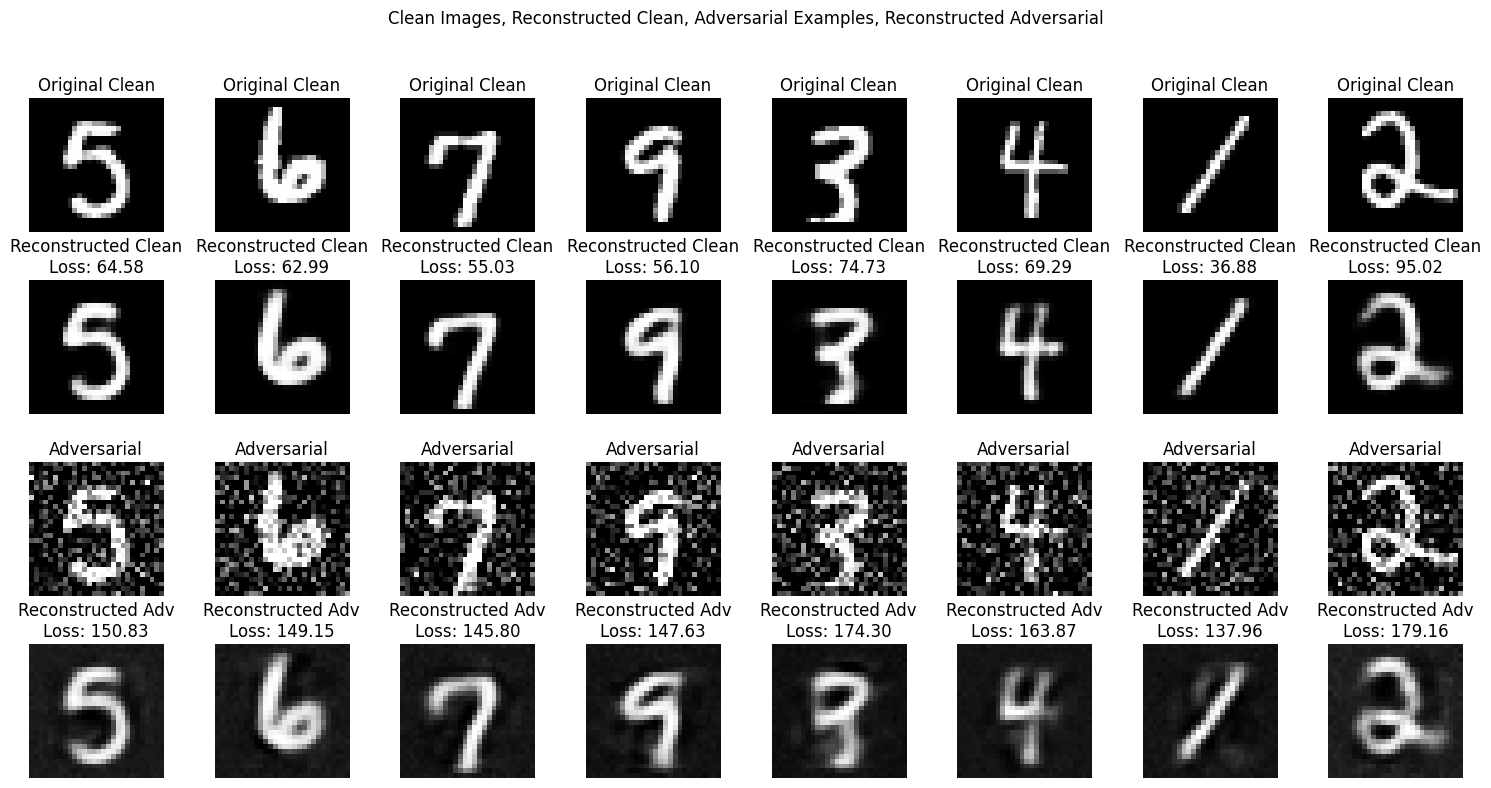

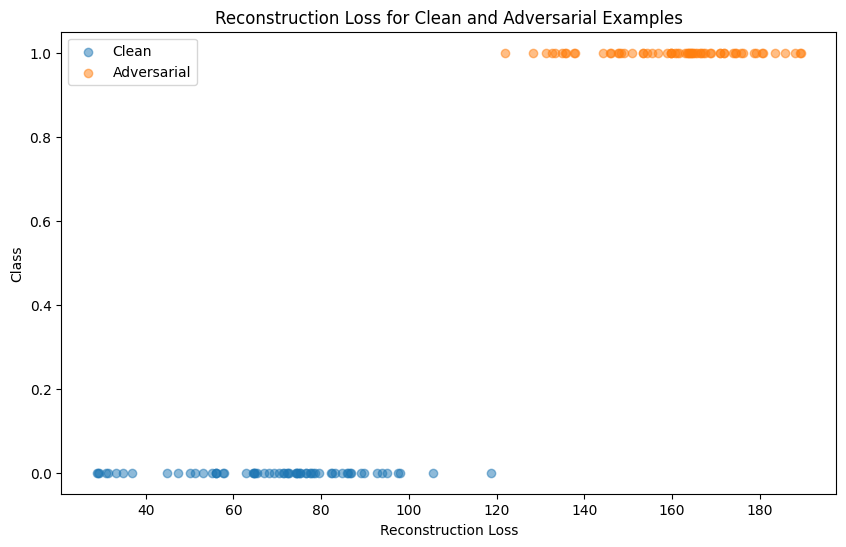

In [13]:
# Parameters
NOISE_LEVEL = 0.3
EPOCHS = 6
MARGIN = 300.0

import math


# Updated loss function to prioritize reconstructing adversarial examples well
def denoising_vae_loss(recon_x, x, mu_clean, logvar_clean, adv_x, recon_adv_x, mu_adv, logvar_adv, margin=5.0):
    # 1. Reconstruction Loss for Clean Examples
    recon_loss_clean = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28 * 28), reduction='sum')

    # 2. Reconstruction Loss for Adversarial Examples
    recon_loss_adv = nn.functional.binary_cross_entropy(recon_adv_x, adv_x.view(-1, 28 * 28), reduction='sum')

    # 3. KL Divergence Loss for Clean Examples
    kl_loss_clean = -0.5 * torch.sum(1 + logvar_clean - mu_clean.pow(2) - logvar_clean.exp())

    # 4. KL Divergence Loss for Adversarial Examples
    kl_loss_adv = -0.5 * torch.sum(1 + logvar_adv - mu_adv.pow(2) - logvar_adv.exp())

    # 5. Contrastive Latent Loss (penalize closeness between clean and adversarial latent vectors)
    latent_distance = torch.norm(mu_clean - mu_adv, p=2)  # L2 distance between means of clean and adversarial latent codes
    contrastive_loss = torch.clamp(margin - latent_distance, min=0)  # If latent_distance > margin, contrastive_loss = 0

    # Total loss
    return 2*recon_loss_adv + 2*recon_loss_clean + .2*(kl_loss_adv + kl_loss_clean) # + math.sqrt((MARGIN - recon_loss_clean)**2) 

# Updated training function using the reversed loss
for epoch in range(1, EPOCHS):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 28 * 28).to(torch.float32)
        
        # Generate adversarial examples
        noise = NOISE_LEVEL * torch.randn_like(data)
        adv_images = (data + noise).clamp(0, 1)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass for clean and adversarial images
        recon_clean, mu, logvar = vae(data)
        recon_adv, mu_adv, logvar_adv = vae(adv_images)

        # Compute the reverse loss
        loss = denoising_vae_loss(recon_clean, data, mu, logvar, adv_images, recon_adv, mu_adv, logvar_adv)
        loss.backward()
        train_loss += loss.item()
        
        # Update parameters
        optimizer.step()

    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset)}')

visualize_results()

# Test with Honesty String

In [ ]:
# load rep_reader_scores_dict.pkl
import pickle

with open('rep_reader_scores_mean_dict.pkl', 'rb') as f:
    rep_reader_scores_mean_dict = pickle.load(f)

len(rep_reader_scores_mean_dict["honesty"])

100

In [35]:
# load rep_reader_scores_dict.pkl
import pickle

with open('rep_reader_scores_dict.pkl', 'rb') as f:
    rep_reader_scores_dict = pickle.load(f)

len(rep_reader_scores_dict["honesty"])

100

In [45]:
import numpy as np

print(rep_reader_scores_dict["honesty"][0][:40])
print(np.array(rep_reader_scores_dict["honesty"][0]).shape)

[[np.float64(5.081085681915283), np.float64(2.8798351287841797), np.float64(3.0818629264831543), np.float64(3.3521170616149902), np.float64(3.4847378730773926), np.float64(3.0345475673675537), np.float64(2.896136999130249), np.float64(2.6181552410125732), np.float64(2.4357566833496094), np.float64(2.1896445751190186), np.float64(2.0686490535736084), np.float64(1.4124566316604614), np.float64(1.1450778245925903), np.float64(1.0719624757766724), np.float64(1.2306443452835083), np.float64(1.2455451488494873), np.float64(1.1663373708724976), np.float64(1.0232642889022827), np.float64(0.7469645738601685), np.float64(0.629390299320221), np.float64(0.9044299125671387), np.float64(0.5491407513618469), np.float64(0.4562416672706604), np.float64(0.18858593702316284), np.float64(0.294351190328598), np.float64(0.3020358681678772), np.float64(0.33361950516700745), np.float64(0.1678212583065033), np.float64(0.10885998606681824), np.float64(0.1458398401737213), np.float64(0.1115279495716095)], [np.fl

In [36]:
print(rep_reader_scores_mean_dict["honesty"][0][:40])

[np.float64(1.0685556570688883), np.float64(0.9805691619714101), np.float64(1.7035440867145857), np.float64(1.8877329250176749), np.float64(1.641126007338365), np.float64(1.928735856215159), np.float64(1.582719580332438), np.float64(1.4988926216959952), np.float64(1.7126273095607758), np.float64(1.3337453414375584), np.float64(1.2770788967609406), np.float64(1.3762955576181413), np.float64(0.8941883087158203), np.float64(1.5863821398466826), np.float64(0.9561805496613185), np.float64(0.949369818965594), np.float64(1.69668221672376), np.float64(1.4393660684737066), np.float64(1.0009405074020228), np.float64(1.6706151912609737), np.float64(1.2962594697872798), np.float64(0.9748197489728531), np.float64(1.3700761119524638), np.float64(0.9661381979628155), np.float64(0.6190747946500779), np.float64(0.9509433231626948), np.float64(0.9506927224497), np.float64(0.829019378622373), np.float64(1.3403675476710002), np.float64(1.6411117911338806), np.float64(0.919636083394289), np.float64(0.97670

In [29]:
LAMBDA = 1.2
INPUT_DIM = 40*1 # was 28*28
HIDDEN_DIM = INPUT_DIM // 2
BOTTLNECK_DIM = 20   # random was 20 with hidden dim 400 
MARGIN = 50


class VEC_VAE(nn.Module):
    def __init__(self):
        super(VEC_VAE, self).__init__()
        # Encoder layers
        self.fc1 = nn.Linear(INPUT_DIM, HIDDEN_DIM)
        self.fc2_mu = nn.Linear(HIDDEN_DIM, BOTTLNECK_DIM)   # Mean of the latent space
        self.fc2_logvar = nn.Linear(HIDDEN_DIM, BOTTLNECK_DIM)  # Log variance of the latent space
        # Decoder layers
        self.fc3 = nn.Linear(BOTTLNECK_DIM, HIDDEN_DIM)
        self.fc4 = nn.Linear(HIDDEN_DIM, INPUT_DIM)
    
    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        mu = self.fc2_mu(h1)
        logvar = self.fc2_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))  # Apply Sigmoid here to keep values in [0, 1]

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, INPUT_DIM))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function for VAE with contrastive loss
import torch.nn.functional as F

# Updated loss function to prioritize reconstructing adversarial examples well
def contrastive_loss(recon_noisy, noisy_input, recon_clean, clean_input, mu, logvar, alpha=2, beta=.1, gamma=0.1):
    """
    Computes a contrastive VAE loss that maximizes reconstruction for noisy inputs 
    while minimizing reconstruction for clean inputs to achieve separability.
    
    Parameters:
    - recon_noisy: VAE reconstruction for the noisy input
    - noisy_input: Original noisy (adversarial) input
    - recon_clean: VAE reconstruction for the clean input
    - clean_input: Original clean input
    - mu, logvar: Mean and log-variance from the encoder
    - margin: Target margin for poor clean reconstructions
    - alpha, beta, gamma: Weighting coefficients for each loss component
    
    Returns:
    - loss: The computed contrastive VAE loss
    """
    
    # 1. Noisy Reconstruction Loss (to be minimized)
    recon_loss_clean = F.mse_loss(recon_noisy, clean_input.view(-1, INPUT_DIM), reduction='sum')
    
    # 2. Clean Reconstruction Loss (contrastive component to be maximized)
    recon_loss_noisy = F.mse_loss(recon_noisy, clean_input.view(-1, INPUT_DIM), reduction='none')
    recon_loss_noisy = torch.sum((MARGIN - recon_loss_noisy.sum(dim=1)).clamp(min=0.0)**2)
    
    # 3. KL Divergence Loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # 4. Total Loss
    total_loss = (alpha * recon_loss_noisy) + (gamma * kl_loss)  # + (beta * recon_loss_clean)
    print(f"recon_loss_noisy: {recon_loss_noisy}, recon_loss_clean: {recon_loss_clean}, kl_loss: {kl_loss}")
    
    return total_loss


vae = VEC_VAE()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [30]:
# data loaded in
clean_data = [rep_reader_scores_mean_dict["honesty"][idx][:40] for idx in range(60,100)]
adversarial_data = [rep_reader_scores_mean_dict["honesty"][idx][:40] for idx in range(10,50)]

clean_test = [rep_reader_scores_mean_dict["honesty"][idx][:40] for idx in range(50,60)]
adversarial_test = [rep_reader_scores_mean_dict["honesty"][idx][:40] for idx in range(0,10)]

In [46]:
import torch
from tqdm import tqdm

# Define the function to batch data
def batch_data(data, batch_size):
    for i in range(0, len(data), batch_size):
        yield torch.tensor(data[i:i + batch_size])

def train(epoch):
    vae.train()
    train_loss = 0

    # Prepare the clean and adversarial data in batches
    clean_batches = batch_data(clean_data, batch_size=32)
    adversarial_batches = batch_data(adversarial_data, batch_size=32)

    # Training step updated to use new data
    for clean_batch, adv_batch in tqdm(zip(clean_batches, adversarial_batches), total=min(len(clean_data), len(adversarial_data)) // 32, disable=True):
        # Clean and adversarial input preparation
        clean_images = clean_batch.to(torch.float32).view(-1, INPUT_DIM)
        adv_images = adv_batch.to(torch.float32).view(-1, INPUT_DIM)
        
        optimizer.zero_grad()
        
        # Forward pass for clean and adversarial examples
        recon_clean, mu, logvar = vae(clean_images)
        recon_adv, _, _ = vae(adv_images)
        
        # Compute loss
        #                       recon_noisy, noisy_input, recon_clean, clean_input, mu, logvar, alpha=2, beta=0.5, gamma=0.1
        loss = contrastive_loss(recon_adv, adv_images, recon_clean, clean_images, mu, logvar, alpha=2, beta=0.5, gamma=2)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    # Print epoch loss
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(clean_data)}')

# Loop through epochs for training
for epoch in range(1, 500):
    train(epoch)


recon_loss_noisy: 72.65571594238281, recon_loss_clean: 2410.673095703125, kl_loss: 82.87421417236328
recon_loss_noisy: 0.0, recon_loss_clean: 598.9603271484375, kl_loss: 17.39870834350586
====> Epoch: 1 Average loss: 8.646432304382325
recon_loss_noisy: 49.92504119873047, recon_loss_clean: 2415.972412109375, kl_loss: 79.59938049316406
recon_loss_noisy: 0.0, recon_loss_clean: 565.9002685546875, kl_loss: 16.546245574951172
====> Epoch: 2 Average loss: 7.303532981872559
recon_loss_noisy: 53.49821090698242, recon_loss_clean: 2404.553955078125, kl_loss: 75.58264923095703
recon_loss_noisy: 0.0, recon_loss_clean: 547.9096069335938, kl_loss: 15.573288917541504
====> Epoch: 3 Average loss: 7.232707262039185
recon_loss_noisy: 65.76233673095703, recon_loss_clean: 2395.211181640625, kl_loss: 71.21907806396484
recon_loss_noisy: 0.5525650382041931, recon_loss_clean: 595.9811401367188, kl_loss: 14.592493057250977
====> Epoch: 4 Average loss: 7.606323623657227
recon_loss_noisy: 50.66103744506836, recon

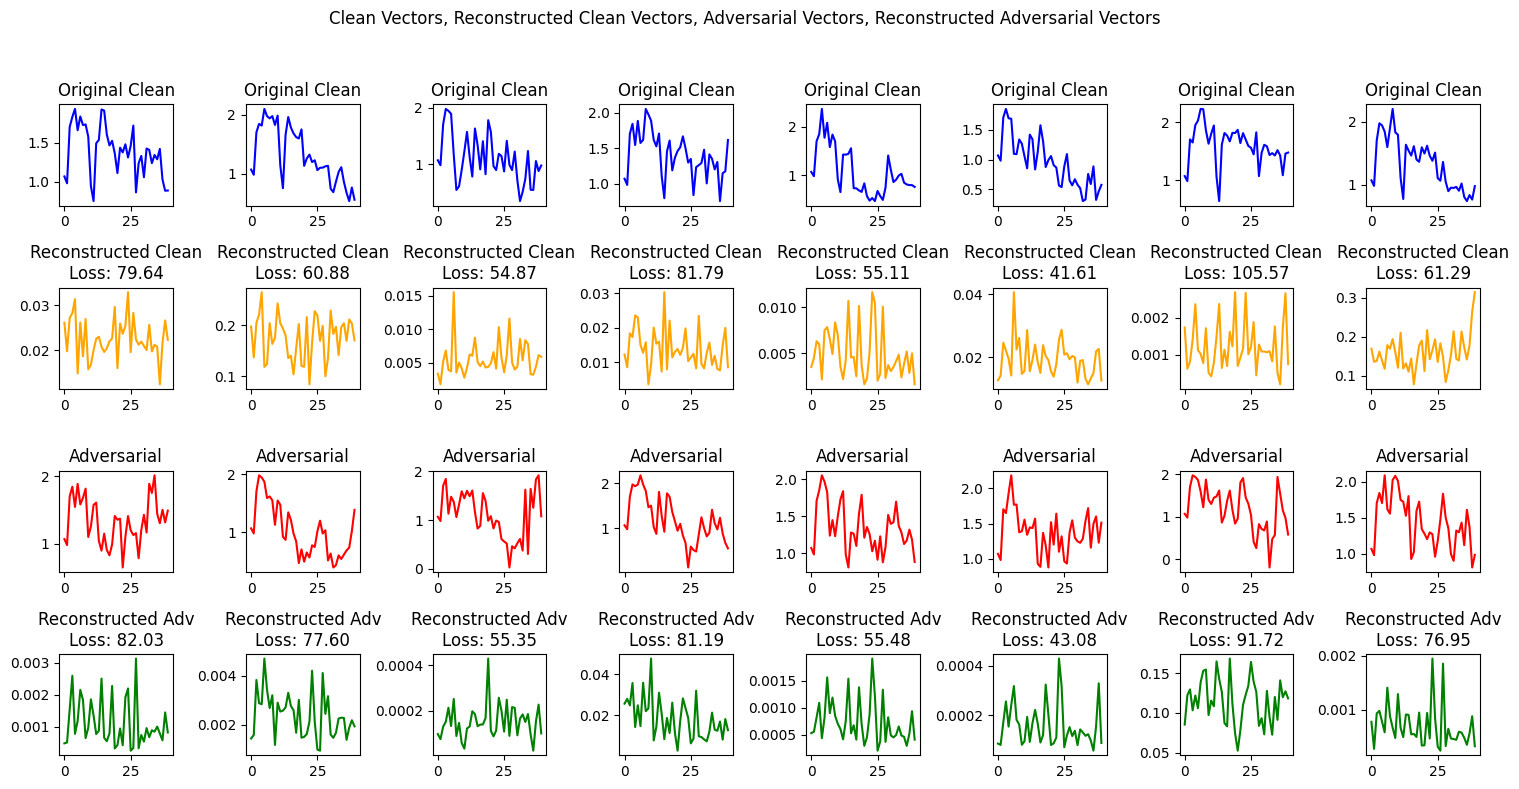

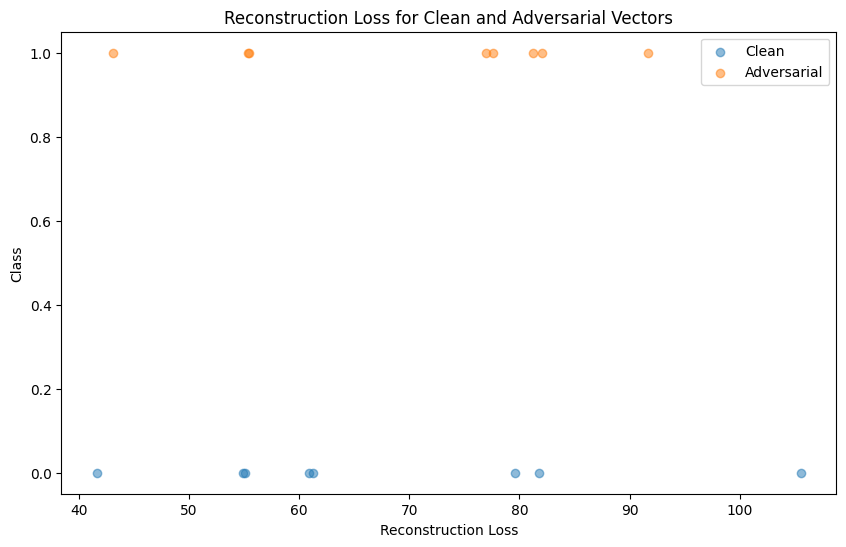

In [47]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Visualize original clean vectors, reconstructed clean vectors, adversarial examples, and their reconstructions
def visualize_results():
    vae.eval()

    with torch.no_grad():
        # Convert clean and adversarial data to tensors and reshape for VAE input
        clean_images = torch.tensor(clean_data[:8], dtype=torch.float32).view(-1, INPUT_DIM)
        adv_images = torch.tensor(adversarial_data[:8], dtype=torch.float32).view(-1, INPUT_DIM)

        # Reconstruct clean and adversarial examples
        recon_clean, _, _ = vae(clean_images)
        recon_adv, _, _ = vae(adv_images)

        # Compute reconstruction loss for clean and adversarial examples using MSE
        recon_loss_clean = F.mse_loss(recon_clean, clean_images, reduction='none').sum(dim=1)
        recon_loss_adv = F.mse_loss(recon_adv, clean_images, reduction='none').sum(dim=1)

        # Visualize results
        fig, axes = plt.subplots(4, 8, figsize=(15, 8))
        fig.suptitle("Clean Vectors, Reconstructed Clean Vectors, Adversarial Vectors, Reconstructed Adversarial Vectors")
        
        for i in range(8):
            # Original Clean Vectors (just plotting the values directly)
            axes[0, i].plot(clean_images[i].cpu().numpy(), label="Original Clean", color='blue')
            # axes[0, i].axis('off')
            axes[0, i].set_title("Original Clean")

            # Reconstructed Clean Vectors
            axes[1, i].plot(recon_clean[i].cpu().numpy(), label="Reconstructed Clean", color='orange')
            # axes[1, i].axis('off')
            axes[1, i].set_title(f"Reconstructed Clean\nLoss: {recon_loss_clean[i].item():.2f}")

            # Adversarial Examples
            axes[2, i].plot(adv_images[i].cpu().numpy(), label="Adversarial", color='red')
            # axes[2, i].axis('off')
            axes[2, i].set_title("Adversarial")

            # Reconstructed Adversarial Examples
            axes[3, i].plot(recon_adv[i].cpu().numpy(), label="Reconstructed Adv", color='green')
            # axes[3, i].axis('off')
            axes[3, i].set_title(f"Reconstructed Adv\nLoss: {recon_loss_adv[i].item():.2f}")

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

        # Plot reconstruction losses
        plt.figure(figsize=(10, 6))
        plt.scatter(recon_loss_clean.cpu().numpy(), np.zeros_like(recon_loss_clean.cpu().numpy()), label='Clean', alpha=0.5)
        plt.scatter(recon_loss_adv.cpu().numpy(), np.ones_like(recon_loss_adv.cpu().numpy()), label='Adversarial', alpha=0.5)
        plt.xlabel('Reconstruction Loss')
        plt.ylabel('Class')
        plt.title('Reconstruction Loss for Clean and Adversarial Vectors')
        plt.legend()
        plt.show()

visualize_results()
